# Consultas Integradas

Este notebook tiene el fin de generar las consultas planteadas en el trabajo práctico integrador

## Importación librerias

Se importan las librerias necesarias para la ejecución de las distintas consignas.

In [ ]:
import os
from pathlib import Path
import pandas as pd
from pymongo.errors import ConnectionFailure
from db_connections import client, db_neo4j, db_redis
from src import mongo, neo4j, utils, redis
from IPython.display import display
import matplotlib.pyplot as plt
from constants import NOMBRE_BD_MONGO
import seaborn as sns

In [ ]:
# =====================
# TEST DE CONEXIONES
# =====================

#Conecto con MongoDB
try:
    client.admin.command("ping")  # fuerza conexión al servidor
    print("✅ Conexión a MongoDB verificada.")
except ConnectionFailure as e:
    print(f"❌ Falló la conexión: {type(e).__name__} - {e}")

#Conecto con Neo4j
try:
    db_neo4j.verify_connectivity()
    print("✅ Conexión a Neo4j verificada.")
except Exception as e:
    print(f"❌ Error de conexión: {type(e).__name__} - {e}")

#Conecto con Redis
try:
    db_redis.ping()
    print("✅ Conexión a Redis verificada.")
except Exception as e:
    print(f"❌ Error de conexión: {type(e).__name__} - {e}")

## 1. Consultas

### A. Mostrar los usuarios que visitaron “Bariloche”. 

Esta sección ejecuta una **consulta en Neo4j** para obtener todos los usuarios que realizaron una visita a la ciudad de **Bariloche**.

    - Query: Se busca la relación `VISITO` entre los nodos `Usuario` y `Destino`, La ciudad de destino se filtra específicamente por `"Bariloche"`.
- Se utiliza la función consulta() que recibe como parametro la base y la query
- Los resultados se devuelven en un **DataFrame de pandas** y se muestran con nombre y apellido de cada usuario. 

In [ ]:
query = """ 
MATCH (U:Usuario)-[:VISITO]->(D:Destino)
WHERE D.ciudad='Bariloche'
RETURN U.nombre AS Nombre, U.apellido AS Apellido
"""

usuarios = neo4j.consulta(db_neo4j, query)

print("\n" + "-"*60)
print("USUARIOS QUE VISITARON BARILOCHE")
print("-"*60)
display(usuarios.style.hide(axis="index"))

### B. Mostrar los amigos de Juan que visitaron algún destino que visitó él, mostrar el nombre del Usuario y el destino. 

Esta sección del código busca mostrar qué amigos visitaron los mismos destinos que el **usuario ingresado por teclado**, utilizando una consulta en **Neo4j** y procesamiento en pandas.

- `input()`: solicita al usuario su nombre para usarlo como filtro en la búsqueda.

- `query`: contiene la instrucción Cypher que busca al `usuario (Usuario)`, sus amigos (`AMIGO_DE`) `y los destinos (VISITO)` que ambos compartieron.

- `consulta()`: ejecuta la query en la base de datos y devuelve los resultados en un DataFrame.

- `apply(lambda lista: ", ".join(lista)):` transforma las listas de ciudades en texto legible.

- `display()`: presenta los resultados en una tabla formateada; si no hay coincidencias, informa que no se encontraron destinos compartidos.

In [ ]:
# Pedimos el nombre del usuario
nombre_usuario = input("Introduce tu nombre para saber qué lugares visitaste con tus amigos: ")

query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (u)-[:AMIGO_DE]-(amigo:Usuario)
MATCH (u)-[:VISITO]->(d:Destino)<-[:VISITO]-(amigo)
RETURN 
    amigo.nombre AS Nombre,
    collect(DISTINCT d.ciudad) AS Destinos_Compartidos
ORDER BY Nombre
"""


# Ejecutamos la consulta usando la función consulta() que devuelve un DataFrame
usuarios = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

# Convertimos listas a texto legible
usuarios["Destinos_Compartidos"] = usuarios["Destinos_Compartidos"].apply(
    lambda lista: ", ".join(lista) if isinstance(lista, list) else lista
)

# Mostramos el resultado

#Encabezado
print("\n" + "-"*60)
print(f"{nombre_usuario.upper()} TUS AMIGOS VISITARON ESTOS MISMOS DESTINOS QUE TÚ")
print("-"*60 + "\n")

#Tabla
if usuarios.empty:
    print("No se encontraron amigos que hayan visitado los mismos destinos.")
else:
    display(usuarios.style.hide(axis="index"))

### C. Sugerir destinos a un usuario que no haya visitado él ni sus amigos. 

Esta sección del código identifica **destinos que ni el usuario ni sus amigos han visitado**, utilizando una consulta en **Neo4j** y mostrando los resultados en una tabla formateada.

- `input()`: solicita al usuario su nombre para usarlo como filtro en la búsqueda.

- `query`: contiene la instrucción **Cypher** que busca todos los nodos `Destino` que **no poseen relación `VISITO`** con el usuario ni con ninguno de sus amigos (`AMIGO_DE`), doble `NOT EXIST`.

- `consulta()`: ejecuta la query en la base de datos **Neo4j** y devuelve los resultados en un **DataFrame de pandas**.

- `display()`: presenta los **destinos no visitados** en formato de tabla; si no hay resultados, informa que no existen destinos nuevos disponibles.


In [ ]:
nombre_usuario = input("Introduce tu nombre para saber qué lugares nuevos que no visitaste ni tu ni tus amigos: ")
#Consulta
query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (d:Destino)
WHERE 
  NOT EXISTS { MATCH (d)<-[:VISITO]-(u) } AND
  NOT EXISTS { MATCH (d)<-[:VISITO]-(u)-[:AMIGO_DE]-(amigo) }
RETURN DISTINCT d.ciudad AS Destinos_No_Visitados
ORDER BY d.ciudad
"""
#Destino
destinos = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

#Encabezado 
print("\n" + "-"*60)
print(f"DESTINOS NUEVOS PARA {nombre_usuario.upper()} Y SUS AMIGOS")
print("-"*60 + "\n")

#Tabla
if destinos.empty:
    print("No hay destinos nuevos disponibles.")
else:
    # Mostrar cada destino en lista
     display(destinos.style.hide(axis="index"))

### D. Recomendar destinos basados en viajes de amigos.

Se recomendan destinos utilizando una consulta en Neo4j y mostrando los resultados en un DataFrame de pandas.

- `input()`: solicita al usuario su nombre para usarlo como filtro en la búsqueda.

- `query:` contiene la instrucción Cypher que busca al usuario `(Usuario)` y a sus amigos `(AMIGO_DE)`, obteniendo los destinos `(Destino)` visitados por los amigos que el usuario aún no visitó, en el codigo `WHERE NOT EXISTS { MATCH (u)-[:VISITO]->(d) }` .

- `consulta()`: ejecuta la query en Neo4j y devuelve los resultados en un DataFrame.


In [ ]:
nombre_usuario = input("Introduce tu nombre para saber qué lugares te recomendamos: ")

query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (u)-[:AMIGO_DE]-(amigo:Usuario)
MATCH (amigo)-[:VISITO]->(d:Destino)
WHERE NOT EXISTS { MATCH (u)-[:VISITO]->(d) } 
RETURN DISTINCT d.ciudad AS Destino_Recomendado
ORDER BY d.ciudad
"""

print("\n" + "-"*60)
print(f"RECOMENDACIONES PARA {nombre_usuario.upper()} EN FUNCIÓN DE SUS AMIGOS")
print("-"*60 + "\n")

destinos = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

if destinos.empty:
    print("No hay destinos recomendados nuevos para vos.")
else:
    display(destinos.style.hide(axis="index"))

### E. Listar los hoteles en los destinos recomendados del punto anterior.

Se obtiene los hoteles en los destinos recomendado del punto anterior combinando Neo4j (para recomendaciones de destinos) y MongoDB (para datos de hoteles), y presenta los resultados en un DataFrame de pandas.

- `lista_destinos:` toma los destinos recomendados previamente calculados (Destino_Recomendado) y elimina valores nulos y duplicados.

- `filtro:` define los criterios de búsqueda en MongoDB para obtener solo hoteles en los destinos recomendados  `{"ciudad": {"$in": lista_destinos}}` 

- `proyeccion:` especifica qué campos devolver de la base de datos (nombre, ciudad, direccion) y excluye _id.

- `mongo.obtener_cursor()`: ejecuta la consulta en MongoDB y devuelve un cursor con los hoteles que cumplen el filtro.

- `pd.DataFrame()`: convierte el cursor de MongoDB en un DataFrame para poder visualizarlo fácilmente.

- `display()`: presenta los hoteles encontrados en una tabla ordenada por ciudad y nombre de hotel; si no hay resultados, informa que no se encontraron hoteles disponibles.

In [ ]:
coleccion = "hoteles"

# Lista de destinos recomendados
lista_destinos = destinos["Destino_Recomendado"].dropna().unique().tolist()

if not lista_destinos:
    print("No hay destinos recomendados disponibles.")
else:
    filtro = {"ciudad": {"$in": lista_destinos}}
    proyeccion = {"_id": 0, "nombre": 1, "ciudad": 1, "direccion": 1}

    # Obtener datos de Mongo y convertir a DataFrame
    cursor = mongo.obtener_cursor(
        NOMBRE_BD_MONGO,
        nombre_coleccion=coleccion,
        filtro=filtro,
        proyeccion=proyeccion
    )

    hoteles = pd.DataFrame(list(cursor))

    if hoteles.empty:
        print("No se encontraron hoteles en los destinos recomendados.")
    else:
        # Ordenar por ciudad y luego por nombre de hotel
        display(hoteles.style.hide(axis="index"))

### F. Ver las reservas en proceso, es decir que aún no están concretadas. 

Esta sección del código permite consultar y mostrar reservas temporales almacenadas en Redis, mostrando los datos y el tiempo de vida restante de cada clave.

- `db_redis.keys("reserva_temp:")`: obtiene todas las claves de Redis que comienzan con "reserva_temp:", es decir, todas las reservas en proceso.

- `len(claves)`: calcula la cantidad total de reservas temporales encontradas.

- `input()`: solicita al usuario cuántas reservas desea listar de las encontradas.

- `for clave in claves[:cantidad]:` recorre las  claves  y con `db_redis.hgetall(clave)`: obtiene todos los campos y valores almacenados en la clave tipo hash de Redis.

- `db_redis.ttl(clave):` devuelve el tiempo de vida restante (TTL, Time To Live) de la clave en segundos.

- `print()`: muestra cada clave junto con sus datos y el TTL de manera legible.



In [ ]:
claves = db_redis.keys("reserva_temp:*")
print(f"Cantidad de reservas en proceso {len(claves)}\n")

if claves:
    cantidad = int(input ("¿Cuántas se desean listar?"))
    print(f"Se imprimen las primeras {cantidad}:")
    for clave in claves[:cantidad]:
        datos = db_redis.hgetall(clave)
        tiempo_restante = db_redis.ttl(clave)
        print(f"{clave}: {datos} | TTL: {tiempo_restante} segundos")

### G. Listar los usuarios conectados actualmente. 

Se utiliza `db_redis.keys("usuario:*:sesion")` con el cual se  obtiene todas las claves de Redis que coinciden con el patrón `"usuario:*:sesion"`, es decir, todas las sesiones activas de los usuarios.

- `len(claves)` calcula la cantidad total de usuarios conectados.

- Se recorre todas las claves encontradas y con `clave.split(":")[1]`: extrae el `usuario_id` del nombre de la clave, que está en la segunda posición después de :

- `db_redis.get(clave)`: obtiene el estado de la sesión almacenado en la clave (por ejemplo, activo, inactivo, etc.).

- `db_redis.ttl(clave)`: devuelve el tiempo de vida restante de la sesión en segundos.


In [ ]:
claves = db_redis.keys("usuario:*:sesion")
print(f"Cantidad de usuarios conectados {len(claves)}\n")

if claves:
    print("Usuarios:")
    for clave in claves:
        usuario_id = clave.split(":")[1]
        estado = db_redis.get(clave)
        tiempo_restante = db_redis.ttl(clave)
        print(f"Usuario {usuario_id} → sesión: {estado} | TTL: {tiempo_restante} segundos")

### H. Mostrar los destinos con precio inferior a $100.000



-  `filtro:` construye el criterio de búsqueda (precio_promedio < precio).

-  `proyeccion:` indica los campos a devolver (excluyendo _id).

-  `redis.obtener_cache():` busca primero el resultado en Redis.

- `mongo.obtener_cursor():` consulta MongoDB si no está en caché.

- `redis.guardar_en_cache():` guarda el resultado en Redis con TTL de 300 segundos.

- `pd.DataFrame():` convierte los resultados a DataFrame de pandas, los ordena por destino y los muestra en formato de tabla .

In [ ]:
precio=100000
coleccion = "destinos"
filtro={"precio_promedio": {"$lt": precio}}
proyeccion = {"_id":0}

# Busca en caché y sino consulta en MongoDB
resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,coleccion,filtro=filtro,proyeccion=proyeccion))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
        
df = pd.DataFrame(resultado)
if not df.empty:
    df_ordenado = df.sort_values(by="destino_id")
    display(df_ordenado.style.hide(axis="index"))
else:
    print(f"No existen destinos con precio inferior a {precio}")

### I. Mostrar todos los Hoteles de “Jujuy”.

Esta sección permite obtener información de hoteles en una ciudad específica, utilizando Redis como caché y MongoDB como fuente de datos principal.

- `coleccion y ciudad`: definen la colección y ciudad a consultar.

- `filtro`: criterio de búsqueda en MongoDB/Redis (ciudad = ciudad).

- `proyeccion`: campos a devolver (nombre, ciudad y dirección).

- `redis.obtener_cache()`: intenta recuperar los datos desde Redis primero.

- `mongo.obtener_cursor()`: consulta MongoDB si no hay resultados en caché.

- `redis.guardar_en_cache()`: almacena los resultados en Redis con TTL de 300 segundos.

- Imprime los datos de los hoteles en pantalla 



In [ ]:
coleccion = "hoteles"
ciudad = "San Salvador de Jujuy"
filtro = {"ciudad": ciudad}
proyeccion = {"_id": 0, "nombre": 1, "ciudad": 1, "direccion": 1}

# Busca en caché y sino consulta en MongoDB
resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,nombre_coleccion=coleccion,filtro=filtro,proyeccion=proyeccion))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")

df_hoteles = pd.DataFrame(resultado)

if not df_hoteles.empty:
    df_ordenado = df_hoteles.sort_values(by="nombre")
    display(df_ordenado.style.hide(axis="index"))
else:
     print("No se encontraron hoteles en los destinos recomendados.")       

Consulta hecha en Mongo


nombre,ciudad
Comercializadora Soria S.L. Hotel,San Salvador de Jujuy
Manufacturas Puga & Asociados S.L.L. Hotel,San Salvador de Jujuy


### J. Mostrar la cantidad de hoteles de un destino que guste. 

- `input():` solicita al usuario si quiere agrupar por provincia o ciudad y el nombre del lugar.

- `filtro:` define dinámicamente el criterio de búsqueda según la elección del usuario.

- `campo_agrupacion:` si se agrupa por provincia, se contará por ciudad dentro de esa provincia; si es ciudad, se usa directamente.

- `mongo.contador():` función personalizada que realiza el conteo de hoteles según los parámetros indicados y devuelve un cursor.

In [ ]:
#Pedimos al usuario el tipo de agrupación y el valor a buscar
agrupar = input("¿Querés agrupar por 'provincia' o 'ciudad'? ").strip().lower()
lugar = input(f"Introduce el nombre de la {agrupar}: ").strip().lower().title()

#Definimos el filtro dinámico según la elección
filtro = {agrupar: lugar}

#Si el usuario elige 'provincia', agrupamos por ciudad dentro de esa provincia
if agrupar == "provincia":
    campo_agrupacion = "ciudad"
else:
    campo_agrupacion = agrupar

#Ejecutamos la función para contar hoteles
cursor = mongo.contador(
    nombre_base=NOMBRE_BD_MONGO,
    coleccion="hoteles",
    agrupacion=campo_agrupacion,
    campo_calculo="hotel_id",
    filtrar=filtro
)

#Convertimos el cursor a DataFrame
hoteles = pd.DataFrame(cursor)

#Mostramos resultados
if agrupar == "provincia":
    print(f"\n Hoteles por ciudad dentro de la provincia {lugar.title()}:\n")
else:
    print(f"\n Cantidad de hoteles en la ciudad {lugar.title()}:\n")

display(hoteles)


¿Querés agrupar por 'provincia' o 'ciudad'?  ciudad
Introduce el nombre de la ciudad:  La Plata



 Cantidad de hoteles en la ciudad La Plata:



,_id,hotel_id
0,La Plata,2


### K. Mostrar las actividades de “Ushuaia” del tipo “aventura”.

Esta sección permite obtener actividades *turísticas filtradas por tipo y ciudad, utilizando Redis como caché para optimizar la consulta y MongoDB como fuente de datos principal*.

- `filtro:` define los criterios de búsqueda en función de la ciudad y el tipo de actividad.

- `redis.obtener_cache():` busca en caché los resultados para evitar consultas repetidas a MongoDB.

- `mongo.obtener_cursor():` si no hay datos en Redis, consulta MongoDB y obtiene los documentos según el filtro y la proyección indicada.

- `redis.guardar_en_cache():` guarda los resultados obtenidos de MongoDB en Redis para futuras consultas, con un TTL de 300 segundos.

- `pd.DataFrame():` convierte los resultados en un DataFrame de pandas para facilitar la visualización.

In [ ]:
coleccion = "actividades"
tipo="aventura"
ciudad="Ushuaia"
filtro = {"ciudad":ciudad,"tipo":tipo}
proyeccion = {"_id":0}

resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,coleccion,filtro=filtro,proyeccion=proyeccion))
    print("Consulta hecha en Mongo")
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
    
df = pd.DataFrame(resultado)
if not df.empty:
    df_ordenado = df.sort_values(by="actividad_id")
    display(df_ordenado.style.hide(axis="index"))
else:
    print(f"No existen actividades de tipo {tipo} en {ciudad}")

Consulta hecha en Mongo


actividad_id,nombre,tipo,ciudad,provincia,precio
107,Decentralized executive artificial intelligence,aventura,Ushuaia,Tierra del Fuego,33340


### L. Mostrar la cantidad de reservas concretadas de cada usuario. Mostrar el usuario y la cantidad 

- `coleccion`: nombre de la colección de MongoDB donde están las reservas ("reservas").

- `estados`: lista de estados de reserva a considerar (["Confirmada", "Pagada"]).

- `filtro`: diccionario que filtra las reservas por los estados definidos en `estados`.

- `pipeline`: lista de etapas de agregación de MongoDB que define cómo procesar los datos:
    - `$match`: filtra las reservas según `filtro`.
    - `$group`: agrupa por `usuario_id` y cuenta las reservas concretadas.
    - `$lookup`: une con la colección `usuarios` para obtener información del usuario.
    - `$unwind`: desanida el array de información del usuario.
    - `$project`: selecciona y renombra los campos a mostrar (`Nombre`, `Apellido`, `Reservas_concretadas`).
    - `$sort`: ordena los resultados de mayor a menor según reservas concretadas.
      

- `resultado`: lista con los documentos obtenidos, ya sea desde Redis o desde MongoDB si no estaba en cache.

- `df`: DataFrame de Pandas que contiene la información final lista para mostrar en el notebook.


In [ ]:
coleccion = "reservas"
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$usuario_id",  # este es el ID del usuario
        "Reservas_concretadas": {"$sum": 1}
    }},
    {"$lookup": {
        "from": "usuarios",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del usuario)
        "foreignField": "usuario_id",        # campo en la colección "usuarios"
        "as": "usuario_info"          # nombre del nuevo campo con los datos del usuario
    }},
    {"$unwind": "$usuario_info"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Nombre": "$usuario_info.nombre",
        "Apellido": "$usuario_info.apellido",
        "Reservas_concretadas": 1
    }},
    {"$sort": {"Reservas_concretadas": -1}}
]

resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(client[NOMBRE_BD_MONGO][coleccion].aggregate(pipeline))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
        
df = pd.DataFrame(resultado)
df = df[["Nombre", "Apellido", "Reservas_concretadas"]]
display(df.style.hide(axis="index"))

Consulta hecha en Mongo


Nombre,Apellido,Reservas_concretadas
Gracia,Naranjo,23
Carmen,Roma,22
Ovidio,Romero,21
Georgina,Ferrando,20
Mónica,Roca,20
David,Julián,20
Adrián,Belda,19
Eliseo,Sobrino,19
Cleto,Palomar,18
Gema,Yáñez,18


## 2.Estadísticas

### I.Destino más visitado

Este bloque obtiene los **10 destinos más visitados** según reservas confirmadas o pagadas:

- `estados`: lista de estados de reserva a considerar (["Confirmada", "Pagada"]).

- `filtro`: diccionario que filtra las reservas por los estados definidos en `estados`.

- `pipeline`: lista de etapas de agregación de MongoDB que define cómo procesar los datos:
    - `$match`: filtra las reservas según `filtro`.
    - `$group`: agrupa por `destino_id` y cuenta cuántas veces se visitó cada destino (`Cantidad_Visitas`).
    - `$lookup`: une con la colección `destinos` para obtener información del destino.
    - `$unwind`: desanida el array de información del destino.
    - `$project`: selecciona y renombra los campos a mostrar (`Destino` y `Cantidad_Visitas`).
    - `$sort`: ordena los resultados de mayor a menor según `Cantidad_Visitas`.
    - `$limit`: limita el resultado a los 10 destinos más visitados.

- `resultado`: lista con los documentos obtenidos desde MongoDB.

- `df`: DataFrame de Pandas que contiene la información final lista para mostrar en el notebook.


In [ ]:
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$destino_id",  # este es el ID del destino
        "Cantidad_Visitas": {"$sum": 1}
    }},
    {"$lookup": {
        "from": "destinos",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del destino)
        "foreignField": "destino_id",        # campo en la colección "destino"
        "as": "destino_visitas"          # nombre del nuevo campo con los datos del destino
    }},
    {"$unwind": "$destino_visitas"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Destino": "$destino_visitas.ciudad",
        "Cantidad_Visitas": 1
    }},
    {"$sort": {"Cantidad_Visitas": -1}},
    {"$limit": 10}
]

resultado = list(client[NOMBRE_BD_MONGO].reservas.aggregate(pipeline))
      
df = pd.DataFrame(resultado)
df = df[["Destino", "Cantidad_Visitas"]]
print("Destino mas vistado")
display(df.style.hide(axis="index"))

Se grafica un **barplot horizontal** de los 10 destinos más visitados, usando Seaborn.  
Las barras muestran la cantidad de visitas, se ordenan de mayor a menor y se etiquetan con los valores exactos.  

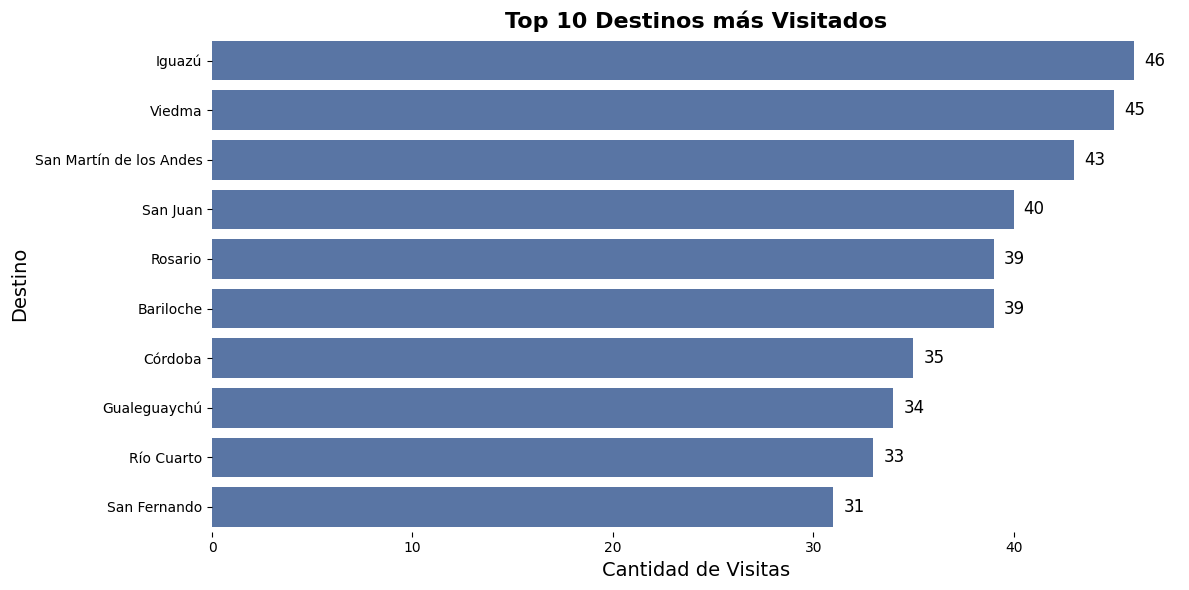

In [ ]:
# Ordenar df por Cantidad_Visitas descendente y tomar top 10
df_top10 = df.nlargest(10, "Cantidad_Visitas")

# Azul clásico de Seaborn
azul_sns = sns.color_palette("deep")[0]

plt.figure(figsize=(12, 6))  # más ancho para legibilidad

ax = sns.barplot(
    data=df_top10,
    y="Destino",
    x="Cantidad_Visitas",
    color=azul_sns
)

# Quitar bordes superior y derecho
sns.despine(left=True, bottom=True)

# Títulos y etiquetas
plt.title("Top 10 Destinos más Visitados", fontsize=16, fontweight="bold")
plt.xlabel("Cantidad de Visitas", fontsize=14)
plt.ylabel("Destino", fontsize=14)

# Mostrar etiquetas de cantidad al final de cada barra
for i, v in enumerate(df_top10["Cantidad_Visitas"]):
    ax.text(v + 0.5, i, str(v), color='black', va='center', fontsize=12, fontweight='medium')

plt.tight_layout()
plt.show()


### II. Hotel más barato

Este bloque obtiene los **10 hoteles más baratos** según reservas confirmadas o pagadas:

estados`: lista de estados de reserva a considerar (["Confirmada", "Pagada"]).

- `filtro`: diccionario que filtra las reservas por los estados definidos en `estados`.

- `pipeline`: lista de etapas de agregación de MongoDB que define cómo procesar los datos:
    - `$match`: filtra las reservas según `filtro`.
    - `$group`: agrupa por `hotel_id` y calcula el precio mínimo (`Precio_minimo`).
    - `$lookup`: une con la colección `hoteles` para obtener información del hotel.
    - `$unwind`: desanida el array de información del hotel.
    - `$project`: selecciona y renombra los campos a mostrar (`Hotel`, `Ciudad`, `Precio_minimo`).
    - `$sort`: ordena los resultados de menor a mayor según `Precio_minimo`.
    - `$limit`: limita el resultado a los 10 hoteles más baratos.

- `resultado`: lista con los documentos obtenidos desde MongoDB.

- `df`: DataFrame de Pandas que contiene la información final lista para mostrar en el notebook.

In [ ]:
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$hotel_id",  # este es id del hotel
        "Precio_minimo": {"$min": "$precio_total"} #el minimo del campo precio_total
    }},
    {"$lookup": {
        "from": "hoteles",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del hotel)
        "foreignField": "hotel_id",        # campo en la colección "usuarios"
        "as": "hoteles_min_precios"          # nombre del nuevo campo con los datos del usuario
    }},
    {"$unwind": "$hoteles_min_precios"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Hotel": "$hoteles_min_precios.nombre",
        "Ciudad": "$hoteles_min_precios.ciudad",
        "Precio_minimo": 1
    }},
    {"$sort": {"Precio_minimo": 1}},
    {"$limit": 10}
]

resultado = list(client[NOMBRE_BD_MONGO]["reservas"].aggregate(pipeline))
      
df = pd.DataFrame(resultado)
df = df[["Hotel", "Ciudad","Precio_minimo"]]
print("Hotel mas barato")
display(df.style.hide(axis="index"))

Hotel mas barato


Hotel,Ciudad,Precio_minimo
Valentín y asociados S.L. Hotel,Río Cuarto,47125
Carmona y asociados S.L.N.E Hotel,Río Cuarto,47990
Hnos Borja S.Com. Hotel,Río Cuarto,48440
Espinosa & Asociados S.C.P Hotel,La Plata,48843
Alcázar & Asociados S.C.P Hotel,San Juan,52015
Tecnologías OAF S.Coop. Hotel,San Juan,52494
Banca Privada AP S.A.U Hotel,San Juan,52875
Inversiones Malo S.Com. Hotel,Puerto Madryn,53235
Hermanos Soria S.Coop. Hotel,La Plata,53918
Soluciones Zorrilla S.A. Hotel,San Juan,54255


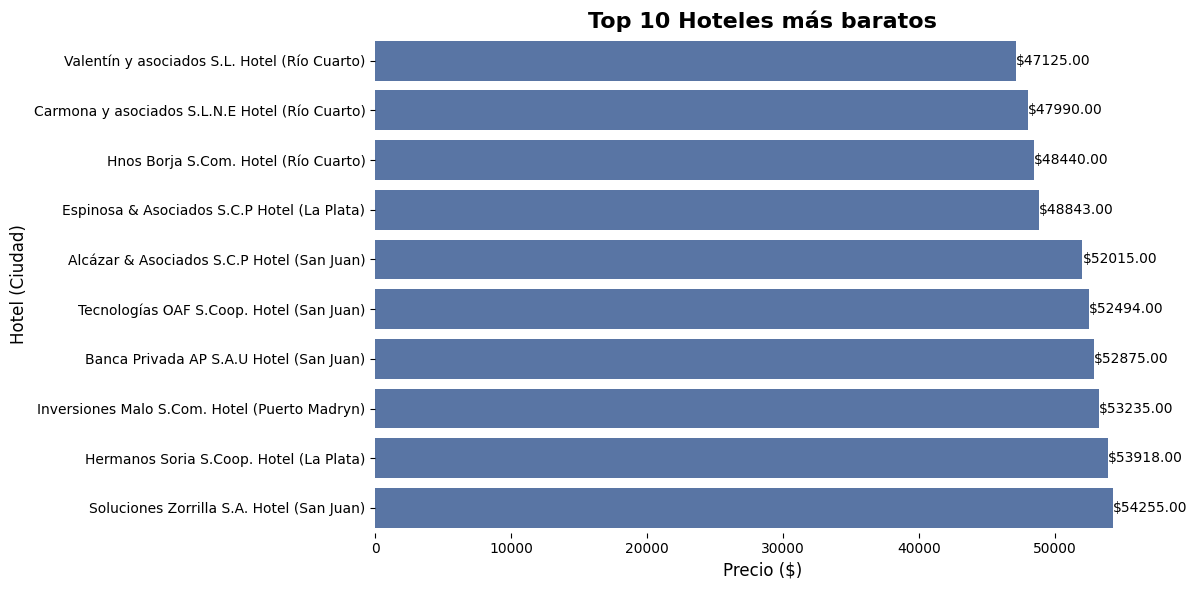

In [ ]:
# Crear columna unificando Hotel y Ciudad
df["Hotel_Ciudad"] = df["Hotel"] + " (" + df["Ciudad"] + ")"

# Configuración del gráfico
plt.figure(figsize=(12, 6))  # más ancho para legibilidad
color_sns = sns.color_palette("deep")[0]

ax = sns.barplot(
    data=df,
    y="Hotel_Ciudad",
    x="Precio_minimo",
    color=color_sns
)

sns.despine(left=True, bottom=True)

# Títulos y etiquetas
plt.title("Top 10 Hoteles más baratos", fontsize=16, fontweight="bold")
plt.xlabel("Precio ($)", fontsize=12)
plt.ylabel("Hotel (Ciudad)", fontsize=12)

# Mostrar etiquetas de precio al final de cada barra
for i, v in enumerate(df["Precio_minimo"]):
    ax.text(v + 0.5, i, f"${v:.2f}", color='black', va='center', fontsize=10)

# Ajuste de layout
plt.tight_layout()
plt.show()


### III. Actividad más popular.

Esta seccón calcula y grafica la **popularidad de cada tipo de actividad** según la cantidad de registros:

- `pipeline`: lista de etapas de agregación de MongoDB que define cómo procesar los datos:
    - `$group`: agrupa por `tipo` y cuenta la cantidad de cada tipo (`cantidad`).
    - `$project`: selecciona y renombra los campos a mostrar (`tipo`, `cantidad`).
    - `$sort`: ordena los resultados de mayor a menor según `cantidad`.

- `resultado`: lista con los documentos obtenidos desde MongoDB.

- `df`: DataFrame de Pandas que contiene la información final lista para mostrar en el notebook.

- `tipos`: lista de tipos de actividad, extraída del DataFrame para graficar.

- `cantidades`: lista con la cantidad de registros por tipo de actividad, extraída del DataFrame para graficar.


tipo,cantidad
relax,30
deportiva,21
cultural,21
aventura,20
gastronómica,19


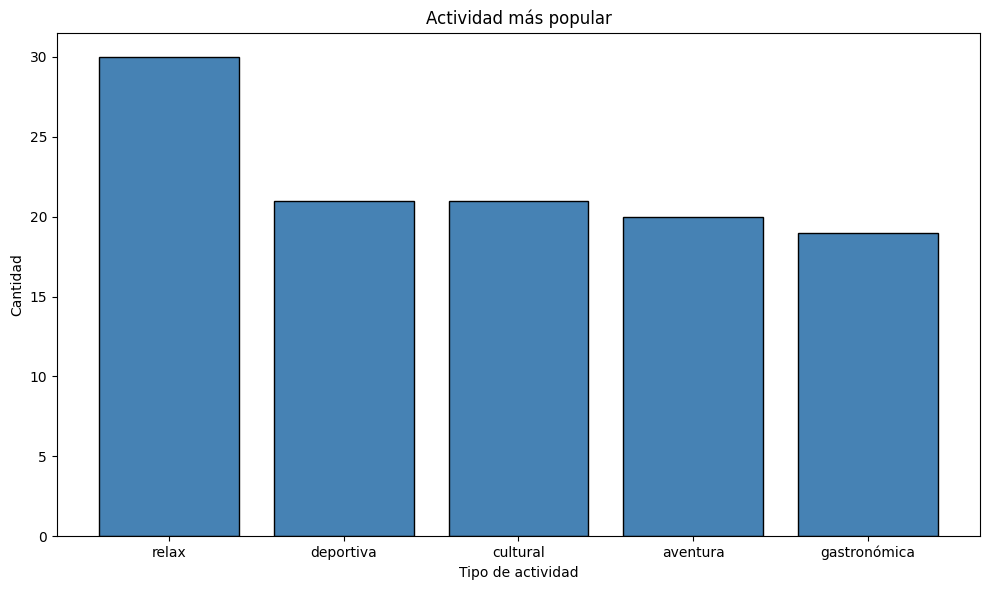

In [ ]:
pipeline = [
    {"$group": {"_id":"$tipo", "cantidad": {"$sum":1}}},
    {"$project":{"_id":0,"tipo":"$_id", "cantidad": 1}},
    {"$sort": {"cantidad": -1}}
]

resultado = list(client[NOMBRE_BD_MONGO]["actividades"].aggregate(pipeline))

df = pd.DataFrame(resultado)
df = df[["tipo", "cantidad"]]
display(df.style.hide(axis="index"))

tipos=df["tipo"]
cantidades= df["cantidad"]

plt.figure(figsize=(10, 6))
plt.bar(tipos, cantidades, color="steelblue", edgecolor="black")

# Etiquetas y título
plt.xlabel("Tipo de actividad")
plt.ylabel("Cantidad")
plt.title("Actividad más popular")
plt.tight_layout()

plt.show()

## 3. Modificaciones

### A. Incrementar el precio de las actividades de Tucuman en 5% 

 - `df_antes`: obtiene los precios actuales (`precio_promedio`) de los destinos según un filtro y los almacena en un DataFrame.  
- `update_many`: aplica un **aumento del 5%** sobre el campo `precio_promedio` en la base de datos.  
- `df_despues`: recupera los precios **después del aumento** y los almacena en un DataFrame.  
- `df_final`: une ambos DataFrames por ciudad para comparar los valores antes y después.  
- `Aumento`: calcula la diferencia entre `precio_despues` y `precio_antes`.  
- La tabla final se muestra **formateada a dos decimales** y sin índice, para una visualización clara.  

---

**Variables principales**

- `coleccion`: colección de MongoDB donde están los destinos.  
- `proyeccion`: campos a traer de la colección (`ciudad` y `precio_promedio`).  
- `filtro`: condición para seleccionar los destinos a actualizar.  
- `cursor_antes`, `cursor_despues`: resultados de MongoDB antes y después del aumento.  
- `df_antes`, `df_despues`: DataFrames de Pandas con los precios antes y después.  
- `df_final`: DataFrame combinado que permite comparar los precios.  
- `Aumento`: columna calculada con la diferencia de precios tras el aumento.


In [ ]:
#------------------------------------------------------------------------------------------------------------------------
# Parametros 
#------------------------------------------------------------------------------------------------------------------------

coleccion="destinos"
proyeccion = {"_id": 0, "ciudad": 1, "precio_promedio": 1}
variacion_precio=1.05
db = mongo.client[NOMBRE_BD_MONGO]

#------------------------------------------------------------------------------------------------------------------------
# Obtener precios antes del aumento
#------------------------------------------------------------------------------------------------------------------------

cursor_antes = mongo.obtener_cursor(
    NOMBRE_BD_MONGO,
    nombre_coleccion=coleccion,
    filtro=filtro,
    proyeccion=proyeccion
)

# Guardo en un DataFrame
df_antes = pd.DataFrame(cursor_antes)
df_antes.rename(columns={"precio_promedio": "precio_antes"}, inplace=True)

#------------------------------------------------------------------------------------------------------------------------
# Aumento 5%
#------------------------------------------------------------------------------------------------------------------------

# Aumentar precio en 5%
db[coleccion].update_many(filtro, {"$mul": {"precio_promedio":variacion_precio}})


# Obtener precios después del aumento
cursor_despues = mongo.obtener_cursor(
    NOMBRE_BD_MONGO,
    nombre_coleccion=coleccion,
    filtro=filtro,
    proyeccion=proyeccion
)

# Guardo en un DataFrame
df_despues = pd.DataFrame(cursor_despues)
df_despues.rename(columns={"precio_promedio": "precio_despues"}, inplace=True)

#------------------------------------------------------------------------------------------------------------------------
# Presentación comparativa
#------------------------------------------------------------------------------------------------------------------------

# Unir DataFrames por nombre del producto
df_final = pd.merge(df_antes, df_despues, on="ciudad")

# Calcular aumento
df_final["Aumento"] = df_final["precio_despues"] - df_final["precio_antes"]

# Mostrar resultados formateados
display(df_final.style.format({
    "precio_antes": "{:.2f}",
    "precio_despues": "{:.2f}",
    "Aumento": "{:.2f}"
}).hide(axis="index"))


ciudad,precio_antes,precio_despues,Aumento
San Miguel de Tucumán,114175.00,119883.75,5708.75


### B. Agregar al hotel id=1 el servicio de SPA 

Agrega un servico a un hotel
- `update_one`: agrega el servicio `"wifi"` al hotel con `hotel_id = 1` usando `$addToSet` (evita duplicados).  
- Verifica si el servicio se agregó:  
  - Si `modified_count == 0`, significa que el servicio ya existía.  
  - Si `modified_count > 0`, muestra cuántos documentos fueron modificados.  
- `obtener_cursor`: consulta la colección para **verificar que el servicio se agregó correctamente**.  
- `resultado`: almacena la información obtenida del hotel después de la actualización, lista para mostrar.








In [ ]:
# Aca usamos la funcion update_one naque hotel

resultado = client[NOMBRE_BD_MONGO].hoteles.update_one(
    {"hotel_id": 1},
    {"$addToSet": {"servicios": "wifi"}}
)

if resultado.modified_count == 0:
    print("El servicio ya existe")
else:
    print(f"Modificados: {resultado.modified_count}")

Modificados: 1


In [ ]:
#Consulta para verificar que se agrego el servicio
cursor = mongo.obtener_cursor(NOMBRE_BD_MONGO,"hoteles",filtro={"hotel_id":1},proyeccion={"_id":0})
resultado = list(cursor)
resultado

[{'hotel_id': 1,
  'nombre': 'Hermanos Soria S.Coop. Hotel',
  'ciudad': 'La Plata',
  'provincia': 'Buenos Aires',
  'precio': 201178,
  'calificacion': 4,
  'servicios': ['restaurant', 'gimnasio', 'spa', 'wifi']}]

### C. Eliminar el destino que desee

Este bloque realiza lo siguiente:

- Solicita al usuario ingresar el **nombre del destino** a eliminar.  
- Construye un **filtro** por ciudad para identificar el destino en la colección `destinos`.  
- `delete_many`: elimina todos los documentos que coincidan con el filtro.  
- Muestra cuántos destinos fueron eliminados.  
- Verifica que el destino ya no exista en la colección:  
  - Si no se encuentra, muestra un ✅ indicando que fue eliminado correctamente.  
  - Si aún existen registros, indica cuántos destinos con ese nombre permanecen.

In [ ]:
destino_eliminar = input("Selecciona un destino a eliminar: ")

# Conectar a la base y colección
coleccion_destinos = db["destinos"]  

# Construir filtro por nombre de destino
filtro = {"ciudad": destino_eliminar}

# Eliminar documento(s) que coincidan
resultado = coleccion_destinos.delete_many(filtro)

# Mostrar mensaje
print(f"Se eliminaron {resultado.deleted_count} destino(s) con el nombre '{destino_eliminar}'")

objeto_eliminado = list(coleccion_destinos.find({"ciudad": destino_eliminar}))
if not objeto_eliminado:
    print(f"✅ El destino '{objeto_eliminado}' ya no existe en la colección.")
else:
    print(f"⚠️ Aún existen {len(objeto_eliminado)} destino(s) con ese nombre.")


Selecciona un destino a eliminar:  La Plata


Se eliminaron 1 destino(s) con el nombre 'La Plata'
✅ El destino '[]' ya no existe en la colección.


### D. Eliminar un usuario que desee 

- `nombre_eliminar`: nombre del usuario que se desea eliminar (ingresado por el usuario).  
- `apellido_eliminar`: apellido del usuario que se desea eliminar (ingresado por el usuario).  
- `coleccion_usuarios`: colección de MongoDB donde se encuentran los usuarios.  
- `filtro`: diccionario que combina `nombre` y `apellido` para buscar/eliminar usuarios específicos.  
- `antes`: lista de documentos que coinciden con el filtro antes de la eliminación, usada para verificar existencia.  
- `resultado`: objeto devuelto por `delete_many`, que contiene información sobre cuántos documentos fueron eliminados.  
- `despues`: lista de documentos que coinciden con el filtro después de la eliminación, usada para verificar que la operación fue exitosa.








In [ ]:
# Solicita  nombre y apellido del usuario a eliminar
nombre_eliminar = input("Escriba el nombre del usuario a eliminar: ")
apellido_eliminar = input("Escriba el apellido del usuario a eliminar: ")

#------------------------------------------------------------------------------------------------
#                                Eliminar de Mongo
#------------------------------------------------------------------------------------------------  

# Conectar a la colección de usuarios
coleccion_usuarios = db["usuarios"]

# Construir filtro por nombre y apellido
filtro = {"nombre": nombre_eliminar, "apellido": apellido_eliminar}

# Buscar si existe antes de eliminar
antes = list(coleccion_usuarios.find(filtro))
if antes:
    print(f"Se encontraron {len(antes)} usuario(s) con ese nombre y apellido:")
    for i in antes:
        print(f" - {i}")
else:
    print("No se encontró ningún usuario con ese nombre y apellido.")

# Eliminar documento
resultado = coleccion_usuarios.delete_many(filtro)
print(f"\nSe eliminaron {resultado.deleted_count} usuario(s).")

# Verificar que se eliminó
despues = list(coleccion_usuarios.find(filtro))
if not despues:
    print(f"✅ El usuario '{nombre_eliminar} {apellido_eliminar}' ya no existe en la colección.")
else:
    print(f"⚠️ Aún existen {len(despues)} usuario(s) con ese nombre y apellido.")


#------------------------------------------------------------------------------------------------
#                                Eliminar de Neo4j - Nodos y sus relaciones
#------------------------------------------------------------------------------------------------  

# Eliminar de Relaciones
query = """
MATCH (u:Usuario {nombre: $nombre, apellido: $apellido})
DETACH DELETE u
"""
with neo4j.session() as session:
    result = session.run(query, nombre=nombre_eliminar, apellido=apellido_eliminar)
    print(f"Usuario '{nombre_eliminar} {apellido_eliminar}' y sus relaciones fueron eliminados de Neo4j.")

query_verificar = """
MATCH (u:Usuario {nombre: $nombre, apellido: $apellido})
RETURN count(u) AS cantidad
"""
if resultado[0]["cantidad"] == 0:
    print(f"✅ El usuario '{nombre_eliminar} {apellido_eliminar}' fue eliminado correctamente de Neo4j.")
else:
    print(f"⚠️ El usuario '{nombre_eliminar} {apellido_eliminar}' aún existe en Neo4j.")



Escriba el nombre del usuario a eliminar:  Juan
Escriba el apellido del usuario a eliminar:  Lopez


No se encontró ningún usuario con ese nombre y apellido.

Se eliminaron 0 usuario(s).
✅ El usuario 'Juan Lopez' ya no existe en la colección.


### E. Eliminar las relaciones AMIGO_DE para un usuario que quiera. 

- Solicita al usuario ingresar el `usuario_id` cuyas relaciones `AMIGO_DE` se desean eliminar.  
- `eliminar_amigos`: función que elimina todas las relaciones `AMIGO_DE` de ese usuario en Neo4j.  
- Muestra cuántas relaciones fueron eliminadas.  
- Consulta de verificación: busca en Neo4j todas las relaciones `AMIGO_DE` del usuario para confirmar la eliminación.  
- `resultado`: almacena la información de la consulta de verificación, mostrando si aún existen relaciones.

In [ ]:
usuario_id = int(input("Ingrese el Usuario ID para borrar las relaciones AMIGO_DE: "))
eliminadas = neo4j.eliminar_amigos(usuario_id)
print(f"Se eliminaron {eliminadas} relaciones AMIGO_DE para el usuario_id: {usuario_id}")

Ingrese el Usuario ID para borrar las relaciones AMIGO_DE:  1


Se eliminaron 16 relaciones AMIGO_DE para el usuario_id: 1


In [ ]:
#Consulta para verificar la eliminación

query = """
MATCH (u:Usuario {usuario_id: $id})-[r:AMIGO_DE]-(amigo:Usuario)
RETURN u.usuario_id,type(r) as relacion,amigo.usuario_id
"""

resultado = neo4j.consulta(db_neo4j, query, parametros={"id": 15})
resultado

,u.usuario_id,relacion,amigo.usuario_id
0,15,AMIGO_DE,33
1,15,AMIGO_DE,33
2,15,AMIGO_DE,32
3,15,AMIGO_DE,32
4,15,AMIGO_DE,53
5,15,AMIGO_DE,53
6,15,AMIGO_DE,36
7,15,AMIGO_DE,36
8,15,AMIGO_DE,25
9,15,AMIGO_DE,25
